In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np

# Figures plotted inside the notebook
# High quality figures

----------------------------------------------------
Machine Learning                      

**Emilio Parrado Hernández, Vanessa Gómez Verdejo, Pablo Martínez Olmos**

----------------------------------------------------



# Homework 1: Support Vector Machines

## Distributed SVM

# Introduction

In this notebook we are going to work on techniques to solve with SVM a problem in which the number of observations in the training set is reasonably large. In these cases **we give up on getting the global SVM that we would obtain by training with all the observations** and try to approximate it with two strategies that involve solving SVMs with training set sizes that we can afford.
Specifically we will address two main approximation strategies:
- **Bagging SVMs**: Train several SVMs, each with a subset of the training data and determine the predictions for the test set by combining the individual predictions of each SVM (majority voting).
- **Distributed SVM**: Exploit the result of the dispersion of the SVM solution. Since the support vectors are the **only observations we really need to construct the SVM**, we can employ the SVMs trained with the reduced size training subsets to try to **detect the support vectors of the global SVM that we would obtain by training with all the observations** and try to approximate this SVM by training only with those global SVM support vector candidates.
The parameters with which we are going to evaluate each of the approximations are:
  - accuracy in classifying the same test set
  - estimation of the computational cost of the implementation


# Data loading

In this notebook we are going to work with the *benchmark* **ijcnn1** database. This set was used during a *challenge* competition organized at the 2001 IJCNN (*International Joint Conference on Neural Networks*) conference.

The dataset is already partitioned into training and test. The following code loads both partitions, assuming that the `ijcnn1.bz2` and `ijcnn1.t.bz2` files are already downloaded to the directory where the notebook is located and, later, normalize the data.

In [ ]:
"""
To work with colab
"""

from google.colab import files
uploaded = files.upload()

Saving ijcnn1.t.bz2 to ijcnn1.t.bz2
Saving ijcnn1.bz2 to ijcnn1.bz2


In [ ]:
from sklearn.datasets import load_svmlight_file
# Data loading
DATA_DIR = './'
Xtrain,Ytrain = load_svmlight_file(DATA_DIR+'ijcnn1.bz2')
Xtest, Ytest = load_svmlight_file(DATA_DIR + 'ijcnn1.t.bz2')
Xtrain = np.asarray(Xtrain.todense())
Xtest = np.asarray(Xtest.todense())
for aa,bb in zip([Xtrain, Xtest],['training', 'test']):
    print("Loaded {0:d} observations of {2} with {1:d} features".format(aa.shape[0], aa.shape[1], bb))


Loaded 49990 observations of training with 22 features
Loaded 91701 observations of test with 22 features


In [ ]:
from sklearn.preprocessing import StandardScaler
# Data normalization
sc = StandardScaler()
Xtrain_s = sc.fit_transform(Xtrain)
Xtest_s = sc.transform(Xtest)

# 1. Baselines

The first step is to establish the *baseline* classifiers against which we are going to compare the results of the models we are training along the *notebook*.



### Exercise 1

Train the following baseline models:

1. DummyClassifier: for this model, first, analyze the class imbalance in the training data.

2. Logistic regression: this is a fast linear classification model that we can train with all training data. Don't forget to select `C` by CV.

3. SVM classifier (limiting the number of samples): as a first no-linear model, let's consider a SCV model with RBF kernel. As the hyperparameter estimation is a rather computationally expensive process, for this section you can use a simplified version at 5000 observations of the training set. In this case, don't forget to cross validate the regularization parameter `C` and the  kernel parameter `gamma`.


Compare the training times needed for the training of the logistic regression model vs the SVC.

Finally, for the purposes of the following sections, save the best model of the SVC() (the one trained with the CV parametes) into a variable called `best_svc`.

### Solution 1

#### 1.1 Dummy classifier

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(Xtrain_s, Ytrain)
dummy_clf.score(Xtest_s, Ytest)

0.9049955834723722

#### 1.2. Logistic regression

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Pipeline definition. List with all the stages of the pipeline
# Elegir valores para C
v_C = [1e-2, 1e-1, 1, 10, 100, 1000]
params = {'C':v_C}

# CV
lr = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid=params, cv=5)

lr.fit(Xtrain_s, Ytrain)

print("Training data accuracy={0:.2f}%".format(100.0 * lr.score(Xtrain_s, Ytrain)))
print("Test data accuracy={0:.2f}%".format(100.0 * lr.score(Xtest_s, Ytest)))
print("Slightly better performance than the trivial model")


Training data accuracy=92.48%
Test data accuracy=92.02%
Slightly better performance than the trivial model
CPU times: user 7.86 s, sys: 2.74 s, total: 10.6 s
Wall time: 7.95 s


#### 1.3. Support Vector Machine


In [ ]:
%%time

# Randomly select about 5000 samples from the training set.
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
X1,  X2,Y1, Y2 = train_test_split(Xtrain_s, Ytrain, test_size=0.9)
print("Selected {0:d} observations from the training set".format(len(Y1)))

# Choose values for C
v_C = [1e-2, 1e-1, 1, 10, 100]

# Choose values for gamma
v_gamma = np.array([1e-3, 1e-2, 1e-1, 1, 10])*X1.shape[1]

params = {'kernel':['rbf'], 'C':v_C, 'gamma':v_gamma}

# CV
grid_svm = GridSearchCV(SVC(), param_grid=params, cv=5)

# Training
grid_svm.fit(X1, Y1)

print(grid_svm.best_params_)

print("Training data accuracy={0:.2f}%".format(100.0 * lr.score(Xtrain_s, Ytrain)))
print("Test data accuracy={0:.2f}%".format(100.0 * lr.score(Xtest_s, Ytest)))
print("They are also slightly better than the trivial model.")

Selected 4999 observations from the training set
{'C': 100, 'gamma': 0.022, 'kernel': 'rbf'}
Training data accuracy=92.48%
Test data accuracy=92.02%
They are also slightly better than the trivial model.
CPU times: user 2min 7s, sys: 157 ms, total: 2min 7s
Wall time: 2min 9s


Save best SVM

In [ ]:
best_svc = grid_svm.best_estimator_

# 2. Computational cost estimation

Comparing the training time of the logistic regressor with the SVM, we can already see that the latter is much longer and has only used a subset of the training data. So, in order to draw conclusions, let's actually calculate the computational cost of SVM as a function of the number of training data.

We give you this code developed because it will be useful for the following sections, but review it and discuss the final results.




To calculate this time, first, we will estimate the cost of training a SVM as a function of the training set size for different training set sizes of 1000, 2000, ..., 9000, 10000 observations (stored in `v_S`) and we will use the function [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to estimate this time (this function not only estimates the model error but also its training time, saved in `fit_time`). For this experiment, we will use the SVM `best_svc` that we have trained in the previous section with those values of `C` and `gamma` to save the CV process.

In [ ]:
best_svc = grid_svm.best_estimator_
from sklearn.model_selection import cross_validate
v_S = np.linspace(1000,10000,10)
v_S = np.linspace(1000,20000,20)
average_fit_time_svm = np.empty(len(v_S))
for ii, ss in enumerate(v_S):
    Xa, Xb, Ya, Yb = train_test_split(Xtrain_s, Ytrain, test_size=(len(Ytrain)-ss)/len(Ytrain))
    cv_results = cross_validate(best_svc, Xa, Ya, cv=10)
    average_fit_time_svm[ii] = np.mean(cv_results['fit_time'])



The following figure plots the average costs of training the SVM as a function of the training set size obtained in the previous cell and compares it to various polynomials. **Discuss which polynomial cost best approximates the cost of training the SVM**.

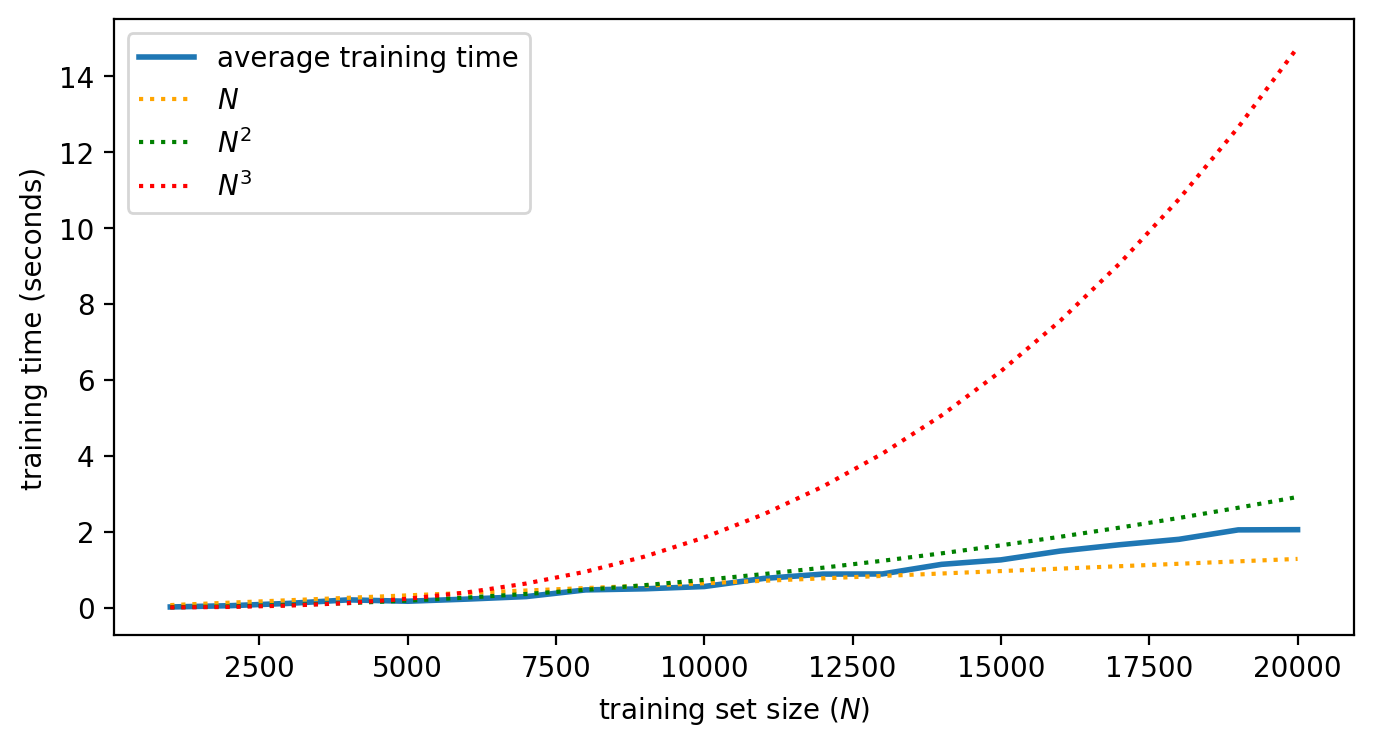

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(v_S, average_fit_time_svm, linewidth=2, label='average training time')
plt.xlabel('training set size ($N$)')
plt.ylabel('training time (seconds)')
cc = np.mean(average_fit_time_svm / v_S)
cc3 = np.mean(average_fit_time_svm / v_S**3)
cc2 = np.mean(average_fit_time_svm / v_S**2)
plt.plot(v_S, v_S*cc, color='orange', linestyle=':', label='$N$')
plt.plot(v_S, v_S**2*cc2, color='green', linestyle=':', label='$N^2$')
plt.plot(v_S, v_S**3*cc3, color='red', linestyle=':',label='$N^3$')

plt.legend()


**Answer:** From theory we know that the training cost of the SVM, solving a QP problem, is on the order of $N^3$, but here we see that it is between $N$ and $N^2$. That is because the optimizers have been designed specifically for this problem and instead of solving the QP problem, they use stochastic gradient descend algorithms. In the case of the sklearn optimizer this cost can be reduced to the order of O(ND^2) if D<N. Despite this reduction, the cost can be prohibitive with very large N.

Now, we are going to automate the calculation of the cost of training an SVM from the data collected in the previous cell. To do this we are going to create an object [`PchipInterpolator`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.PchipInterpolator.html) that receives requests in the form of training set size and returns an estimate in seconds of the cost of training an SVM with it.

Time to train an SVM with 4534 samples: 0.182 seconds


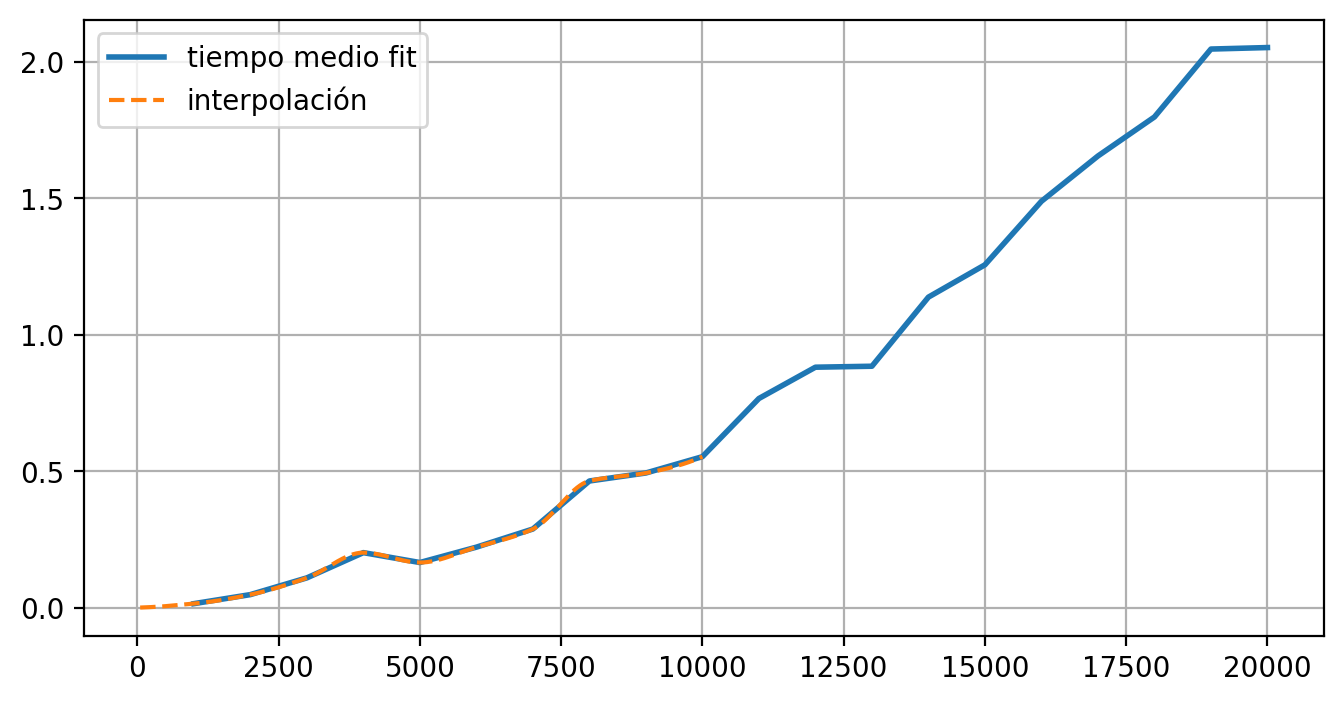

In [ ]:
from scipy import interpolate
xs = np.hstack((np.zeros(1), v_S))
ys = np.hstack((np.zeros(1), average_fit_time_svm))
interpolate_time_svm = interpolate.PchipInterpolator(xs, ys)
ss = 4534
tt = interpolate_time_svm(ss)
print("Time to train an SVM with {0:d} samples: {1:.3f} seconds".format(ss,tt))
plt.figure(figsize=(8,4))
xx = np.hstack((np.linspace(50,500,1000),np.linspace(1000,10000,1000)))
plt.plot(v_S, average_fit_time_svm, linewidth=2, label='tiempo medio fit')
plt.plot(xx, interpolate_time_svm(xx), linestyle='--', label='interpolación')
plt.legend()
plt.grid()

# 3. Strategies for solving a problem with SVMs when the training set is large.



## 3.1 First strategy: Bagging SVMs


The first strategy is to train an *ensemble* where the role of the *weak learner* is played by SVMs. Since the SVM is a reasonably sophisticated classifier these *ensembles* need not be very numerous. **We will test set sizes such that the heaviest SVMs would be trained with at most about 5000 observations**.


In fact, the elements of the array `v_G` are going to determine the *ensemble* sizes we are going to test (`v_G=xx` means an ensemble with $xx$ SVMs).


### Exercise 2

In the following cell write code that implements a loop that traverses the elements of `v_G` performing the following functionalities:
- Determine the maximum number of observations to train each *weak-learner* of the *ensemble* `max_samples`. The value of `max_samples` for each *ensemble* size must be such that the product of `max_samples` times the *ensemble* size is the size of the original training set {`Xtrain_s, Ytrain`}. Store this value in the corresponding position of `v_max_samples`.


- Train a *bagging* of SVMs using the `best_svm`model (with the optimal SVM hyperparameters found in Section 2.1). For this, you can use the `BaggingClassifier` class of sklearn with the corresponding `max_samples`and `n_estimators` arguments.

- Compute the accuracy over the test data.

- Use the interpolator of the cost of training an SVM to calculate the computational cost of training the *ensemble*.

For each iteration of this process, save the test accuracy, the estimated training time and the *bagging* model (save the models in a dictionary with the key `n_estimators` corresponding to the iteration).

In [ ]:
v_G = np.linspace(11,51,5).astype(int)

# Variables to save results
v_max_samples = np.empty(len(v_G))
acc_bagging = np.empty(len(v_G))
time_bagging = np.empty(len(v_G))
dict_bagging = {}

### Solution 2

In [ ]:
#############
# YOUR CODE #
#############
from sklearn.ensemble import BaggingClassifier
for ii, n_estimators in enumerate(v_G):
    max_samples = int(len(Ytrain)/n_estimators)+1
    v_max_samples[ii] = max_samples
    baggingSVC = BaggingClassifier(estimator=best_svc,
                                   max_samples=max_samples,
                                   n_estimators=n_estimators)
    baggingSVC.fit(Xtrain_s, Ytrain)
    acc_bagging[ii] = baggingSVC.score(Xtest_s, Ytest)
    time_bagging[ii] = interpolate_time_svm(max_samples) * n_estimators
    dict_bagging[n_estimators] = baggingSVC
#######
# END #
#######

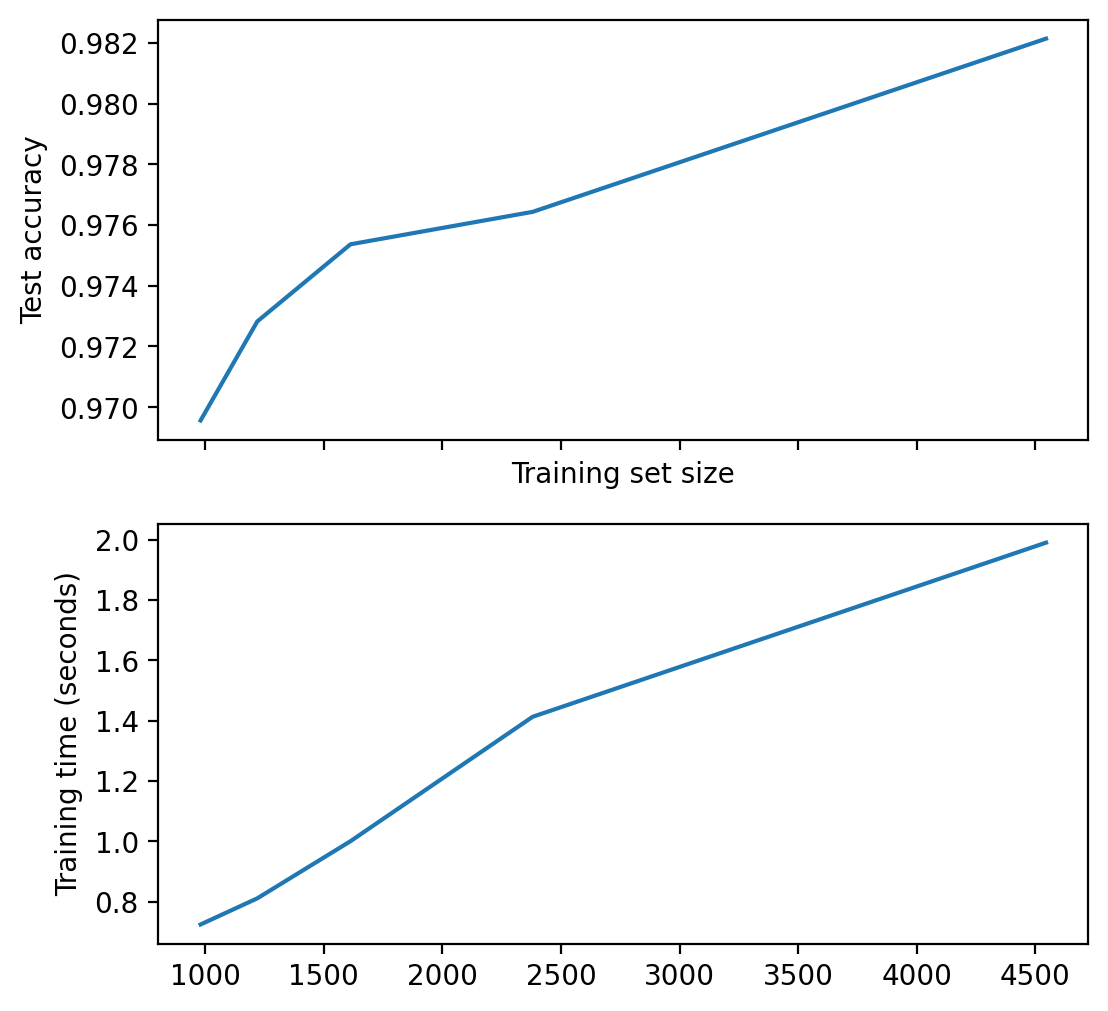

In [ ]:
ff,aa = plt.subplots(2,1,figsize=(6,6),sharex=True)
aa[0].plot(v_max_samples[::-1], acc_bagging[::-1])
aa[0].set_xlabel('Training set size')
aa[0].set_ylabel('Test accuracy')

aa[1].plot(v_max_samples[::-1], time_bagging[::-1])
_=aa[1].set_ylabel('Training time (seconds)')


## 3.2 Second strategy: Global SVM with support vectors of the bagged SVMs
There is an alternative to obtaining the final predictions as the majority class predicted by all the SVMs that form the *bagging ensemble*. This alternative is based on exploiting the sparsity of the SVM solution and the property that the support vectors contain all the information needed to solve the problem. The support vectors of each SVM of the *ensemble* are critical samples for the definition of the classification boundary. Therefore, we are going to use them to construct a global **SVM** using the **support vectors identified by each SVM of the ensemble**.


### Exercise 3

Train a global SVM with the support vectors of the bagged SVMs

In the `bagged_svm.estimators_` attribute there is a list with the SVMs that form the *ensemble*. Write code that implements a loop that loops through the values of `v_G`. At each $gg$ iteration of this loop implement an inner loop that traverses the $gg$ elements of the *ensemble* and extracts their support vectors. Store these support vectors in the same array, which will serve as the training set for the global SVM.

**Note**. Within an `SVC` object there are two attributes that are of interest to solve this section:
- `support_vectors_` has the support vectors.
- `dual_coef_` has the Lagrange multipliers ($\alpha_i$) corresponding to the support vectors **multiplied** by the support vector label ($y_i$), then it can be used to retrieve the original support vector target.

Once you have the training set formed by the support vectors, train an SVM with it employing the optimal hyperparameters found at the beginning of the notebook.

Evaluate the test set with this global SVM and store the result in the corresponding position of the `accuracy_bagging_SVM`.

In [ ]:
# Variables to save results
acc_bagging_SVM = np.empty(len(v_G))
time_bagging_SVM = np.empty(len(v_G))

### Solution 3

In [ ]:
#############
# YOUR CODE #
#############
for ii, n_estimators in enumerate(v_G):
    baggingSVC = dict_bagging[n_estimators]
    for jj,clf in enumerate(baggingSVC.estimators_):
        if jj==0:
            Xg = clf.support_vectors_
            Yg = np.ones(Xg.shape[0])
            Yg[clf.dual_coef_[0]<0] = -1
        else:
            Xg = np.vstack((Xg, clf.support_vectors_))
            yy = np.ones(clf.support_vectors_.shape[0])
            yy[clf.dual_coef_[0]<0] = -1
            Yg = np.hstack((Yg, yy))
    globalSVC = best_svc
    globalSVC.fit(Xg, Yg)
    acc_bagging_SVM[ii] = globalSVC.score(Xtest_s, Ytest)
    time_bagging_SVM[ii] += interpolate_time_svm(len(Yg))
#######
# END #
#######

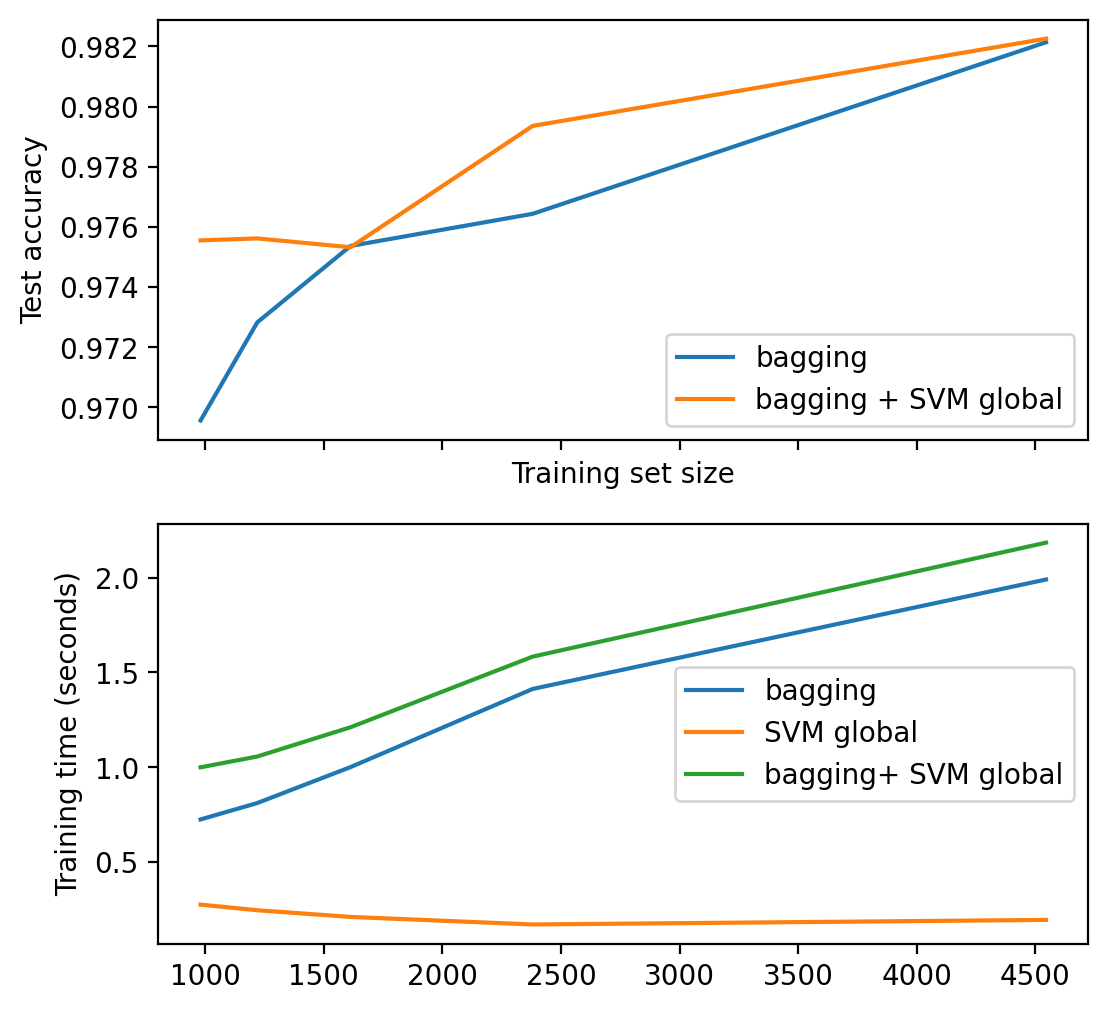

In [ ]:
ff,aa = plt.subplots(2,1,figsize=(6,6),sharex=True)
aa[0].plot(v_max_samples[::-1], acc_bagging[::-1], label='bagging')
aa[0].plot(v_max_samples[::-1], acc_bagging_SVM[::-1], label='bagging + SVM global')

aa[0].set_xlabel('Training set size')
aa[0].set_ylabel('Test accuracy')

aa[0].legend()
aa[1].plot(v_max_samples[::-1], time_bagging[::-1], label='bagging')
aa[1].plot(v_max_samples[::-1], time_bagging_SVM[::-1], label='SVM global')
aa[1].plot(v_max_samples[::-1], time_bagging[::-1]+time_bagging_SVM[::-1], label='bagging+ SVM global')

_=aa[1].set_ylabel('Training time (seconds)')
aa[1].legend()

## 3.3. Discussion of the results

In view of these results discuss the advantages and disadvantages of each strategy.